In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf
import datetime
import random

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [3]:
plt.rcParams.update({'font.size': 13})

This notebook will mainly focus on data exploration and "enhancement".
- looking at outliers (but not doing anything with them)
- looking for duplicates
- looking for NaN values
- "Enhancements"
    - adding columns for school holidays, public holidays and holidays
    - adding columns for workday
    - adding a column with lockdown information

# Uploading the Data

#### Data Set Information:

Bicycle data in Karlsruhe, Germany.

#### Attribute Information
- `bike_count`: Number of bikes, which drove by the counting station during the day

- `temperature`: Temperature in °C

- `humidity`: Relative humidity in %

- `windspeed`: Windspeed in m/s, faulty values = -999

- `wind_direction`: Wind direction in °, faulty values = -999

- `precipitation`: Precipitation in mm (hourly sum)

- `precip_ind`: Precipitation indicator
  - 0 = no
  - 1 = yes
  - -999 = faulty

- `precip_type`:
  - 0 = no precipitation (conventional or automatic measurement)
  - 1 = just rain (in historical data before 01.01.1979)
  - 4 = Precipitation form unknown, although precipitation reported; Form of falling and deposited precipitation cannot be clearly determined with automatic measurement
  - 6 = Only rain; liquid precipitation in automatic measurement
  - 7 = Only snow; solid precipitation in automatic measurement
  - 8 = Rain and snow and/or sleet; liquid and solid precipitation in automatic measurement
  - 9 = Misidentification; missing value or precipitation form not determinable with automatic measurement
  - -999 = Faulty value

- `sun`: Hourly sunshine duration in minutes, Faulty value = -999 (Hourly sum)

- `visibility`: Visibility in 

Notiz: precip type und precip indicator wurden mit dem median auf den tag angepasstmeters, Faulty values = -999
V.Sichtweite: Sichtwe eprüft, gepflegt, nicht korrigiert;

In [4]:
df = pd.read_csv(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\2012-04-25_2024-01-25_KA_bike_weather.csv")

In [5]:
df_schoolholiday = pd.read_csv(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\schulferien_BW_2012_2024.csv")

In [6]:
#save a copy of the raw data
df_raw = df.copy()

In [7]:
# change date column to datetime
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0


In [8]:
df.tail()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
4286,2024-01-21,994.0,-1.500000,87.666667,1.587500,187.500000,14942.500000,0.0,191,7.7,0.0,0.0
4287,2024-01-22,3398.0,7.479167,76.791667,7.075000,223.750000,47245.416667,5.4,0,18.0,1.0,6.0
4288,2024-01-23,4427.0,8.358333,74.541667,7.250000,231.250000,38257.916667,0.5,164,16.6,0.5,3.0
4289,2024-01-24,4124.0,11.945833,72.291667,8.350000,234.583333,45765.833333,1.9,7,18.8,0.0,0.0
4290,2024-01-25,4594.0,9.366667,85.083333,3.345833,229.583333,23374.583333,1.0,220,7.5,0.0,0.0


In [9]:
df_schoolholiday.head()

,start,end,year,stateCode,name
0,2012-10-29,2012-11-02,2012,BW,herbstferien
1,2012-12-24,2013-01-05,2012,BW,weihnachtsferien
2,2013-03-25,2013-04-05,2013,BW,osterferien
3,2013-05-21,2013-06-01,2013,BW,pfingstferien
4,2013-07-25,2013-09-07,2013,BW,sommerferien


In [10]:
df_schoolholiday.tail()

,start,end,year,stateCode,name
64,2024-05-21,2024-05-31,2024,BW,pfingstferien
65,2024-07-25,2024-09-07,2024,BW,sommerferien
66,2024-10-28,2024-10-30,2024,BW,herbstferien
67,2024-10-31,2024-10-31,2024,BW,herbstferien
68,2024-12-23,2025-01-04,2024,BW,weihnachtsferien


# Cleaning the Data

In [11]:
df.isna().sum()

date              0
bike_count        0
temperature       0
humidity          0
windspeed         0
wind_direction    0
visibility        0
precipitation     0
sun               0
windspeed_max     0
precip_indic      0
precip_type       0
dtype: int64

Checking for missing dates...

In [12]:
# Generate a complete range of dates spanning the desired period
complete_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# Find the missing dates by comparing the complete range with the actual dates in the DataFrame
missing_dates = complete_range[~complete_range.isin(df['date'])]

# Print the missing dates
print("Missing dates:")
print(missing_dates)

Missing dates:
DatetimeIndex(['2018-04-15', '2018-04-16'], dtype='datetime64[ns]', freq='D')


In [13]:
df[df['date'].isin(missing_dates)]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type


## Checking for outliers

In [14]:
df.shape

(4291, 12)

In [15]:
df.describe()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
count,4291,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000
mean,2018-03-10 23:36:10.403169280,4735.174603,12.538591,73.092589,3.475722,176.768780,34281.616807,1.539361,309.323701,9.544232,0.192205,1.162666
min,2012-04-25 00:00:00,273.000000,-7.827778,31.277778,0.600000,16.666667,207.777778,0.000000,0.000000,2.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,3220.000000,6.427778,62.611111,2.144444,129.722222,21317.777778,0.000000,33.000000,7.000000,0.000000,0.000000
50%,2018-03-10 00:00:00,4880.000000,12.450000,74.666667,3.122222,206.666667,35432.222222,0.000000,246.000000,9.000000,0.000000,0.000000
75%,2021-02-16 12:00:00,6208.000000,18.705556,84.111111,4.355556,228.888889,46983.611111,1.000000,548.000000,11.700000,0.000000,0.000000
max,2024-01-25 00:00:00,16149.000000,31.794444,100.000000,12.233333,340.000000,71937.777778,58.300000,909.000000,31.000000,1.000000,8.000000
std,NaN,1981.068801,7.636231,14.120612,1.816690,69.225224,16381.273131,3.911284,280.267835,3.956637,0.384261,2.320596


How many rows are there with a bike count over a certain number?

In [16]:
def count_rows_by_condition(df, column, condition, threshold):
    if condition == 'larger':
        filtered_df = df[df[column] > threshold]
    elif condition == 'smaller':
        filtered_df = df[df[column] < threshold]
    elif condition == 'equal':
        filtered_df = df[df[column] == threshold]
    else:
        raise ValueError("Condition must be 'larger', 'smaller', or 'equal'.")
    
    number_of_rows = len(filtered_df)
    
    if condition == 'equal':
        print(f"There are {number_of_rows} entries equal to {threshold}.")
    else:
        print(f"There are {number_of_rows} entries {condition} than {threshold}.")

    return filtered_df

In [17]:
count_rows_by_condition(df, 'bike_count', 'larger', 10000)

There are 11 entries larger than 10000.


,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
2202,2018-05-08,13109.0,21.122222,41.388889,4.377778,50.000000,28496.111111,0.0,833,10.9,0.0,0.0
2203,2018-05-09,12701.0,20.533333,48.666667,3.055556,82.777778,36868.333333,0.0,714,9.0,0.0,0.0
2222,2018-05-28,10200.0,24.516667,65.333333,3.266667,70.000000,14847.222222,0.0,570,9.8,0.0,0.0
2230,2018-06-05,13292.0,24.144444,58.777778,3.122222,80.000000,24607.222222,0.0,806,10.2,0.0,0.0
2231,2018-06-06,13538.0,23.711111,62.500000,2.422222,185.555556,16275.000000,2.0,678,6.3,0.0,0.0
2232,2018-06-07,13316.0,21.488889,75.388889,2.772222,230.000000,25608.333333,3.3,212,5.9,0.0,0.0
2233,2018-06-08,16149.0,22.727778,71.944444,2.055556,152.222222,15031.111111,2.9,575,9.0,0.0,0.0
2234,2018-06-09,14357.0,22.283333,78.111111,2.688889,238.888889,14092.777778,2.0,480,8.1,0.0,0.0
2238,2018-06-13,15952.0,16.533333,63.388889,4.100000,203.888889,36424.444444,0.0,16,9.3,0.0,0.0
2288,2018-08-02,13450.0,29.683333,49.000000,2.391667,337.500000,33195.000000,0.0,626,7.2,0.0,0.0


In [18]:
count_rows_by_condition(df, 'bike_count', 'larger', 15000)

There are 2 entries larger than 15000.


,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
2233,2018-06-08,16149.0,22.727778,71.944444,2.055556,152.222222,15031.111111,2.9,575,9.0,0.0,0.0
2238,2018-06-13,15952.0,16.533333,63.388889,4.100000,203.888889,36424.444444,0.0,16,9.3,0.0,0.0


Interestingly, all the highest bike counts were measured in 2018.

## Checking for duplicates

In [19]:
duplicates_df = df.duplicated()
print('Number of duplicates: ' + str(duplicates_df.sum()))

Number of duplicates: 0


# "Enhancing" the Data

i.e. adding the holiday data
-> public holidays and school holidays

### Adding Data for School Holidays

In [20]:
df_schoolholiday.head()

,start,end,year,stateCode,name
0,2012-10-29,2012-11-02,2012,BW,herbstferien
1,2012-12-24,2013-01-05,2012,BW,weihnachtsferien
2,2013-03-25,2013-04-05,2013,BW,osterferien
3,2013-05-21,2013-06-01,2013,BW,pfingstferien
4,2013-07-25,2013-09-07,2013,BW,sommerferien


In [21]:
df_schoolholiday['start'] = pd.to_datetime(df_schoolholiday['start'])
df_schoolholiday['end'] = pd.to_datetime(df_schoolholiday['end'])

In [22]:
print(complete_range)

DatetimeIndex(['2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04',
               ...
               '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19',
               '2024-01-20', '2024-01-21', '2024-01-22', '2024-01-23',
               '2024-01-24', '2024-01-25'],
              dtype='datetime64[ns]', length=4293, freq='D')


In [23]:
df_schoolholiday.shape

(69, 5)

In [24]:
holiday_dates = pd.concat([pd.DataFrame({
    'date': pd.date_range(start, end, freq='D'),
    'name': name
}) for start, end, name in zip(df_schoolholiday['start'], df_schoolholiday['end'], df_schoolholiday['name'])], ignore_index=True)


In [25]:
holiday_dates.iloc[0:10]

,date,name
0,2012-10-29,herbstferien
1,2012-10-30,herbstferien
2,2012-10-31,herbstferien
3,2012-11-01,herbstferien
4,2012-11-02,herbstferien
5,2012-12-24,weihnachtsferien
6,2012-12-25,weihnachtsferien
7,2012-12-26,weihnachtsferien
8,2012-12-27,weihnachtsferien
9,2012-12-28,weihnachtsferien


In [26]:
len(df)

4291

In [27]:
df = pd.merge(df, holiday_dates, on='date', how='left')

In [28]:
len(df)

4359

In [29]:
df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,name
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,NaN
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,NaN
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,NaN
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,NaN
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,NaN


In [30]:
df.isna().sum()

date                 0
bike_count           0
temperature          0
humidity             0
windspeed            0
wind_direction       0
visibility           0
precipitation        0
sun                  0
windspeed_max        0
precip_indic         0
precip_type          0
name              3293
dtype: int64

In [31]:
duplicates_df = df.duplicated()
print('Number of duplicates: ' + str(duplicates_df.sum()))

Number of duplicates: 68


In [32]:
df = df.drop_duplicates()

In [33]:
len(df)

4291

In [34]:
df.dtypes

date              datetime64[ns]
bike_count               float64
temperature              float64
humidity                 float64
windspeed                float64
wind_direction           float64
visibility               float64
precipitation            float64
sun                        int64
windspeed_max            float64
precip_indic             float64
precip_type              float64
name                      object
dtype: object

In [35]:
df['school_holiday'] = df['name'].fillna('No Holiday')

In [36]:
df['school_holiday_indicator'] = df['name'].notna().astype(int)

In [37]:
df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,name,school_holiday,school_holiday_indicator
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,NaN,No Holiday,0
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,NaN,No Holiday,0
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,NaN,No Holiday,0
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,NaN,No Holiday,0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,NaN,No Holiday,0


In [38]:
len(df)

4291

In [39]:
df = df.drop(columns=['name'])

In [40]:
df.iloc[186:193]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator
186,2012-10-28,1266.0,2.672222,79.833333,3.366667,36.111111,19444.444444,0.0,291,9.0,0.0,0.0,No Holiday,0
187,2012-10-29,4541.0,0.483333,92.055556,1.905556,226.666667,10122.222222,0.0,59,6.0,0.0,0.0,herbstferien,1
188,2012-10-30,4960.0,7.294444,66.277778,6.061111,230.000000,56388.888889,0.0,137,13.0,0.0,0.0,herbstferien,1
189,2012-10-31,5520.0,4.966667,79.777778,1.188889,100.555556,33500.000000,0.0,448,5.0,0.0,0.0,herbstferien,1
190,2012-11-01,1650.0,9.072222,79.166667,3.922222,209.444444,32777.777778,0.4,211,14.0,0.0,0.0,herbstferien,1
191,2012-11-02,3895.0,9.322222,77.555556,5.816667,215.000000,29722.222222,7.1,266,17.0,1.0,6.0,herbstferien,1
192,2012-11-03,2167.0,10.777778,85.722222,4.188889,212.222222,30750.000000,16.1,144,18.0,1.0,6.0,No Holiday,0


In [41]:
df.school_holiday.nunique()

6

In [42]:
df.school_holiday.unique()

array(['No Holiday', 'herbstferien', 'weihnachtsferien', 'osterferien',
       'pfingstferien', 'sommerferien'], dtype=object)

In [43]:
len(df)

4291

### Adding Data for Public Holidays
Public holidays were taken from https://www.kalender-uhrzeit.de/feiertage-2024/baden-wuerttemberg (mit den Jahreszahlen entsprechend angepasst)

In [44]:
df_publicholiday = pd.read_csv(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\Public_holidays_BW.csv")

In [45]:
df_publicholiday.head()

,public_holiday,date
0,Neujahr,2024-01-01
1,Heilige Drei Koenige,2024-01-06
2,Karfreitag,2024-03-29
3,Ostermontag,2024-04-01
4,Tag der Arbeit,2024-05-01


In [46]:
df_publicholiday.shape

(157, 2)

In [47]:
df_publicholiday['date'] = pd.to_datetime(df_publicholiday['date'])

In [48]:
df = pd.merge(df, df_publicholiday, on='date', how='left')

In [49]:
len(df)

4291

In [50]:
df['public_holiday_indicator'] = df['public_holiday'].notna().astype(int)

In [51]:
df['public_holiday'] = df['public_holiday'].fillna('No Holiday')

In [52]:
len(df)

4291

In [53]:
df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,No Holiday,0,No Holiday,0
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,No Holiday,0,No Holiday,0
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,No Holiday,0,No Holiday,0
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,No Holiday,0,No Holiday,0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,No Holiday,0,No Holiday,0


In [54]:
df.iloc[20:30]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator
20,2012-05-15,5209.0,10.377778,68.888889,5.466667,233.888889,31555.555556,0.8,297,16.0,0.5,0.0,No Holiday,0,No Holiday,0
21,2012-05-16,4452.0,9.483333,69.444444,3.972222,278.888889,37388.888889,3.1,273,10.0,1.0,6.0,No Holiday,0,No Holiday,0
22,2012-05-17,2128.0,11.744444,57.888889,3.338889,71.666667,50055.555556,0.0,802,11.0,0.0,0.0,No Holiday,0,Christi Himmelfahrt,1
23,2012-05-18,5332.0,16.483333,58.277778,2.605556,185.555556,51111.111111,0.1,368,7.0,1.0,6.0,No Holiday,0,No Holiday,0
24,2012-05-19,3468.0,18.172222,72.888889,2.472222,89.444444,31238.888889,6.3,513,12.0,0.0,0.0,No Holiday,0,No Holiday,0
25,2012-05-20,2103.0,20.388889,68.111111,2.766667,56.666667,36238.888889,0.0,663,8.0,0.0,0.0,No Holiday,0,No Holiday,0
26,2012-05-21,6353.0,18.955556,74.055556,3.883333,238.333333,24055.555556,1.9,317,14.0,0.0,0.0,No Holiday,0,No Holiday,0
27,2012-05-22,6363.0,19.583333,72.166667,2.333333,275.555556,29055.555556,0.0,379,6.0,0.0,0.0,No Holiday,0,No Holiday,0
28,2012-05-23,6339.0,18.711111,86.388889,4.583333,223.888889,4711.111111,0.5,247,8.0,0.0,0.0,No Holiday,0,No Holiday,0
29,2012-05-24,6977.0,22.950000,62.611111,3.116667,111.111111,19233.333333,0.0,638,10.0,0.0,0.0,No Holiday,0,No Holiday,0


In [55]:
df.public_holiday.nunique()

13

In [56]:
df.public_holiday.unique()

array(['No Holiday', 'Tag der Arbeit', 'Christi Himmelfahrt',
       'Pfingstmontag', 'Fronleichnam', 'Tag der Deutschen Einheit',
       'Allerheiligen', 'Weihnachten', 'Neujahr', 'Heilige Drei Koenige',
       'Karfreitag', 'Ostermontag', 'Reformationstag'], dtype=object)

In [57]:
df.describe()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator
count,4291,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000
mean,2018-03-10 23:36:10.403169280,4735.174603,12.538591,73.092589,3.475722,176.768780,34281.616807,1.539361,309.323701,9.544232,0.192205,1.162666,0.232580,0.033326
min,2012-04-25 00:00:00,273.000000,-7.827778,31.277778,0.600000,16.666667,207.777778,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,3220.000000,6.427778,62.611111,2.144444,129.722222,21317.777778,0.000000,33.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,2018-03-10 00:00:00,4880.000000,12.450000,74.666667,3.122222,206.666667,35432.222222,0.000000,246.000000,9.000000,0.000000,0.000000,0.000000,0.000000
75%,2021-02-16 12:00:00,6208.000000,18.705556,84.111111,4.355556,228.888889,46983.611111,1.000000,548.000000,11.700000,0.000000,0.000000,0.000000,0.000000
max,2024-01-25 00:00:00,16149.000000,31.794444,100.000000,12.233333,340.000000,71937.777778,58.300000,909.000000,31.000000,1.000000,8.000000,1.000000,1.000000
std,NaN,1981.068801,7.636231,14.120612,1.816690,69.225224,16381.273131,3.911284,280.267835,3.956637,0.384261,2.320596,0.422526,0.179506


### Adding a holiday indicator

In [58]:
# Adding a column to indicate whether a certain day is a holiday
# Define conditions
condition = (df['public_holiday_indicator'] == 1) | (df['school_holiday_indicator'] == 1)

# Create new column based on conditions
df['holiday_indicator'] = condition.astype(int)

In [59]:
df.iloc[20:30]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator
20,2012-05-15,5209.0,10.377778,68.888889,5.466667,233.888889,31555.555556,0.8,297,16.0,0.5,0.0,No Holiday,0,No Holiday,0,0
21,2012-05-16,4452.0,9.483333,69.444444,3.972222,278.888889,37388.888889,3.1,273,10.0,1.0,6.0,No Holiday,0,No Holiday,0,0
22,2012-05-17,2128.0,11.744444,57.888889,3.338889,71.666667,50055.555556,0.0,802,11.0,0.0,0.0,No Holiday,0,Christi Himmelfahrt,1,1
23,2012-05-18,5332.0,16.483333,58.277778,2.605556,185.555556,51111.111111,0.1,368,7.0,1.0,6.0,No Holiday,0,No Holiday,0,0
24,2012-05-19,3468.0,18.172222,72.888889,2.472222,89.444444,31238.888889,6.3,513,12.0,0.0,0.0,No Holiday,0,No Holiday,0,0
25,2012-05-20,2103.0,20.388889,68.111111,2.766667,56.666667,36238.888889,0.0,663,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0
26,2012-05-21,6353.0,18.955556,74.055556,3.883333,238.333333,24055.555556,1.9,317,14.0,0.0,0.0,No Holiday,0,No Holiday,0,0
27,2012-05-22,6363.0,19.583333,72.166667,2.333333,275.555556,29055.555556,0.0,379,6.0,0.0,0.0,No Holiday,0,No Holiday,0,0
28,2012-05-23,6339.0,18.711111,86.388889,4.583333,223.888889,4711.111111,0.5,247,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0
29,2012-05-24,6977.0,22.950000,62.611111,3.116667,111.111111,19233.333333,0.0,638,10.0,0.0,0.0,No Holiday,0,No Holiday,0,0


In [60]:
df.iloc[185:195]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator
185,2012-10-27,1475.0,2.150000,90.611111,5.955556,76.666667,13361.111111,17.4,0,12.0,1.0,7.0,No Holiday,0,No Holiday,0,0
186,2012-10-28,1266.0,2.672222,79.833333,3.366667,36.111111,19444.444444,0.0,291,9.0,0.0,0.0,No Holiday,0,No Holiday,0,0
187,2012-10-29,4541.0,0.483333,92.055556,1.905556,226.666667,10122.222222,0.0,59,6.0,0.0,0.0,herbstferien,1,No Holiday,0,1
188,2012-10-30,4960.0,7.294444,66.277778,6.061111,230.000000,56388.888889,0.0,137,13.0,0.0,0.0,herbstferien,1,No Holiday,0,1
189,2012-10-31,5520.0,4.966667,79.777778,1.188889,100.555556,33500.000000,0.0,448,5.0,0.0,0.0,herbstferien,1,No Holiday,0,1
190,2012-11-01,1650.0,9.072222,79.166667,3.922222,209.444444,32777.777778,0.4,211,14.0,0.0,0.0,herbstferien,1,Allerheiligen,1,1
191,2012-11-02,3895.0,9.322222,77.555556,5.816667,215.000000,29722.222222,7.1,266,17.0,1.0,6.0,herbstferien,1,No Holiday,0,1
192,2012-11-03,2167.0,10.777778,85.722222,4.188889,212.222222,30750.000000,16.1,144,18.0,1.0,6.0,No Holiday,0,No Holiday,0,0
193,2012-11-04,960.0,9.616667,91.388889,3.227778,173.888889,32666.666667,5.4,10,10.0,1.0,6.0,No Holiday,0,No Holiday,0,0
194,2012-11-05,3894.0,8.250000,88.333333,5.188889,235.000000,34777.777778,10.0,50,12.0,1.0,6.0,No Holiday,0,No Holiday,0,0


In [61]:
len(df) 

4291

### More plots... 

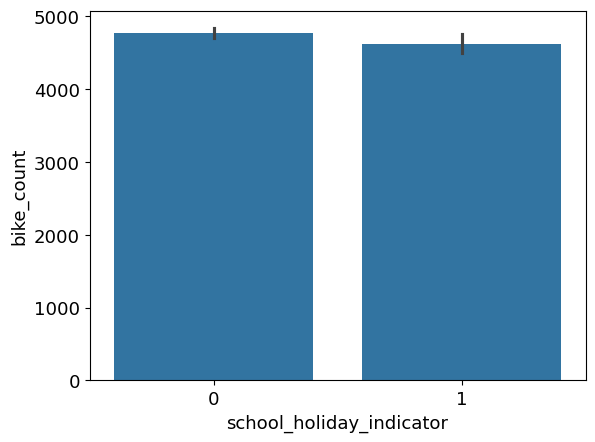

In [62]:
school_holiday_plot = sns.barplot(data=df, x= 'school_holiday_indicator' , y = 'bike_count')
plt.show()

<Axes: xlabel='school_holiday_indicator', ylabel='bike_count'>

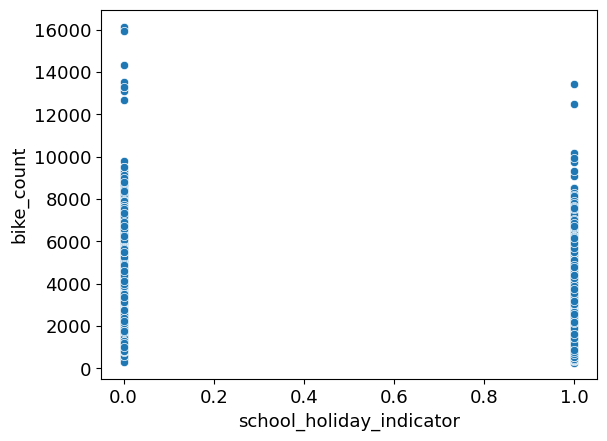

In [63]:
sns.scatterplot(data=df, x='school_holiday_indicator', y='bike_count') 

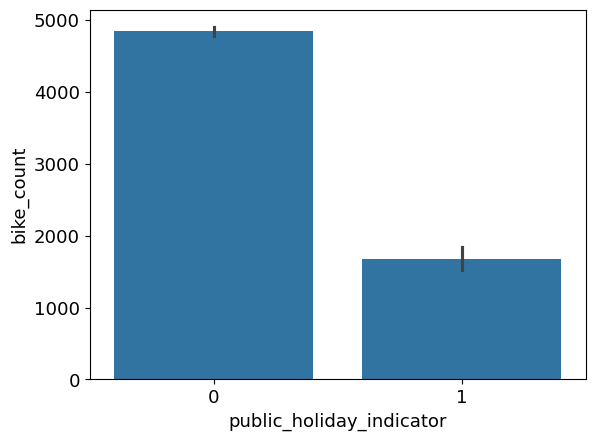

In [64]:
public_holiday_plot = sns.barplot(data=df, x= 'public_holiday_indicator' , y = 'bike_count')
plt.show()

<Axes: xlabel='public_holiday_indicator', ylabel='bike_count'>

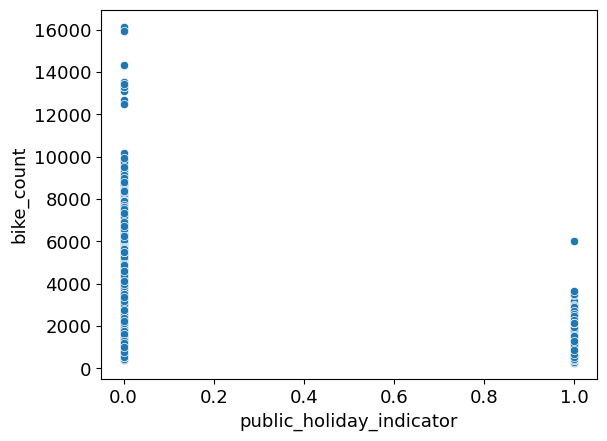

In [65]:
sns.scatterplot(data=df, x='public_holiday_indicator', y='bike_count') 

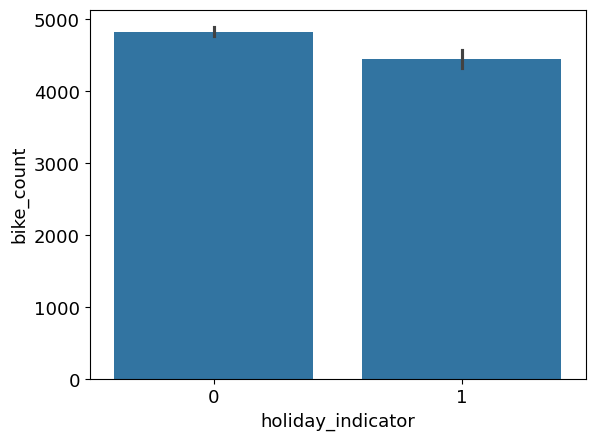

In [66]:
holiday_plot = sns.barplot(data=df, x= 'holiday_indicator' , y = 'bike_count')
plt.show()

Adding a column indication workday or non-work day

In [67]:
# Create a new column to indicate workdays (1) or non-workdays (0)
df['is_workday'] = df.apply(lambda row: 1 if (row['date'].weekday() < 5 and row['public_holiday_indicator'] == 0) else 0, axis=1)

In [68]:
len(df)

4291

#### Checking if everything looks alright

In [69]:
df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0


In [70]:
df.iloc[20:30]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday
20,2012-05-15,5209.0,10.377778,68.888889,5.466667,233.888889,31555.555556,0.8,297,16.0,0.5,0.0,No Holiday,0,No Holiday,0,0,1
21,2012-05-16,4452.0,9.483333,69.444444,3.972222,278.888889,37388.888889,3.1,273,10.0,1.0,6.0,No Holiday,0,No Holiday,0,0,1
22,2012-05-17,2128.0,11.744444,57.888889,3.338889,71.666667,50055.555556,0.0,802,11.0,0.0,0.0,No Holiday,0,Christi Himmelfahrt,1,1,0
23,2012-05-18,5332.0,16.483333,58.277778,2.605556,185.555556,51111.111111,0.1,368,7.0,1.0,6.0,No Holiday,0,No Holiday,0,0,1
24,2012-05-19,3468.0,18.172222,72.888889,2.472222,89.444444,31238.888889,6.3,513,12.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0
25,2012-05-20,2103.0,20.388889,68.111111,2.766667,56.666667,36238.888889,0.0,663,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0
26,2012-05-21,6353.0,18.955556,74.055556,3.883333,238.333333,24055.555556,1.9,317,14.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1
27,2012-05-22,6363.0,19.583333,72.166667,2.333333,275.555556,29055.555556,0.0,379,6.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1
28,2012-05-23,6339.0,18.711111,86.388889,4.583333,223.888889,4711.111111,0.5,247,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1
29,2012-05-24,6977.0,22.950000,62.611111,3.116667,111.111111,19233.333333,0.0,638,10.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1


In [71]:
df.iloc[185:195]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday
185,2012-10-27,1475.0,2.150000,90.611111,5.955556,76.666667,13361.111111,17.4,0,12.0,1.0,7.0,No Holiday,0,No Holiday,0,0,0
186,2012-10-28,1266.0,2.672222,79.833333,3.366667,36.111111,19444.444444,0.0,291,9.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0
187,2012-10-29,4541.0,0.483333,92.055556,1.905556,226.666667,10122.222222,0.0,59,6.0,0.0,0.0,herbstferien,1,No Holiday,0,1,1
188,2012-10-30,4960.0,7.294444,66.277778,6.061111,230.000000,56388.888889,0.0,137,13.0,0.0,0.0,herbstferien,1,No Holiday,0,1,1
189,2012-10-31,5520.0,4.966667,79.777778,1.188889,100.555556,33500.000000,0.0,448,5.0,0.0,0.0,herbstferien,1,No Holiday,0,1,1
190,2012-11-01,1650.0,9.072222,79.166667,3.922222,209.444444,32777.777778,0.4,211,14.0,0.0,0.0,herbstferien,1,Allerheiligen,1,1,0
191,2012-11-02,3895.0,9.322222,77.555556,5.816667,215.000000,29722.222222,7.1,266,17.0,1.0,6.0,herbstferien,1,No Holiday,0,1,1
192,2012-11-03,2167.0,10.777778,85.722222,4.188889,212.222222,30750.000000,16.1,144,18.0,1.0,6.0,No Holiday,0,No Holiday,0,0,0
193,2012-11-04,960.0,9.616667,91.388889,3.227778,173.888889,32666.666667,5.4,10,10.0,1.0,6.0,No Holiday,0,No Holiday,0,0,0
194,2012-11-05,3894.0,8.250000,88.333333,5.188889,235.000000,34777.777778,10.0,50,12.0,1.0,6.0,No Holiday,0,No Holiday,0,0,1


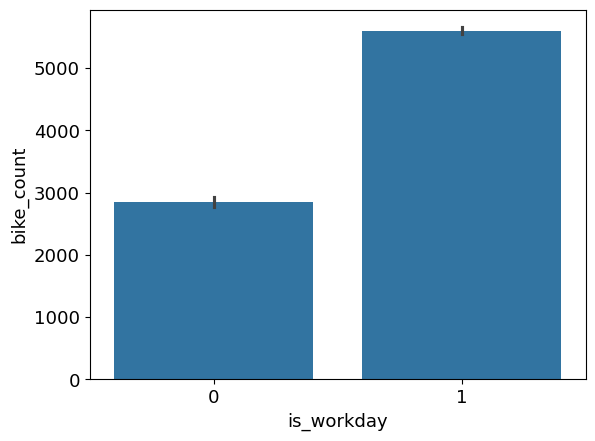

In [72]:
workday_plot = sns.barplot(data=df, x= 'is_workday' , y = 'bike_count')
plt.show()

In [73]:
df.to_csv(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\bike_data_enhanced.csv", index=False)

In [74]:
df.isna().sum()

date                        0
bike_count                  0
temperature                 0
humidity                    0
windspeed                   0
wind_direction              0
visibility                  0
precipitation               0
sun                         0
windspeed_max               0
precip_indic                0
precip_type                 0
school_holiday              0
school_holiday_indicator    0
public_holiday              0
public_holiday_indicator    0
holiday_indicator           0
is_workday                  0
dtype: int64

### Adding information about the COVID-19 lockdown
- 0 = no lockdown 
- 1 = "soft" lockdown 
- 2 = "hard" lockdown

I chose approximate ranges for hard and soft lockdowns. Ranges as seen below

In [75]:
df.dtypes

date                        datetime64[ns]
bike_count                         float64
temperature                        float64
humidity                           float64
windspeed                          float64
wind_direction                     float64
visibility                         float64
precipitation                      float64
sun                                  int64
windspeed_max                      float64
precip_indic                       float64
precip_type                        float64
school_holiday                      object
school_holiday_indicator             int32
public_holiday                      object
public_holiday_indicator             int32
holiday_indicator                    int32
is_workday                           int64
dtype: object

In [76]:
# Define a function to assign the values based on the date ranges
def assign_values(date):
    if pd.Timestamp('2020-06-01') <= date <= pd.Timestamp('2020-09-30'):
        return 1
    elif pd.Timestamp('2021-05-01') <= date <= pd.Timestamp('2022-05-31'):
        return 1
    elif pd.Timestamp('2020-03-01') <= date <= pd.Timestamp('2020-05-31'):
        return 2
    elif pd.Timestamp('2020-10-01') <= date <= pd.Timestamp('2021-04-30'):
        return 2
    else:
        return 0

In [77]:
df['lockdown'] = df['date'].apply(assign_values)

In [78]:
len(df)

4291

In [79]:
df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,lockdown
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0,0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0,0


In [80]:
df.iloc[3022:3027]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,lockdown
3022,2020-08-05,7607.0,21.894444,48.055556,2.711111,76.666667,58240.555556,0.0,812,10.8,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1
3023,2020-08-06,7512.0,24.494444,48.444444,3.777778,66.666667,58312.222222,0.0,810,10.3,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1
3024,2020-08-07,7056.0,27.566667,48.888889,3.333333,55.000000,53134.444444,0.0,800,11.0,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1
3025,2020-08-08,5135.0,28.877778,43.222222,2.338889,123.888889,44113.888889,0.0,787,9.2,0.0,0.0,sommerferien,1,No Holiday,0,1,0,1
3026,2020-08-09,2493.0,28.905556,43.277778,2.516667,141.111111,46730.555556,0.0,769,11.0,0.0,0.0,sommerferien,1,No Holiday,0,1,0,1


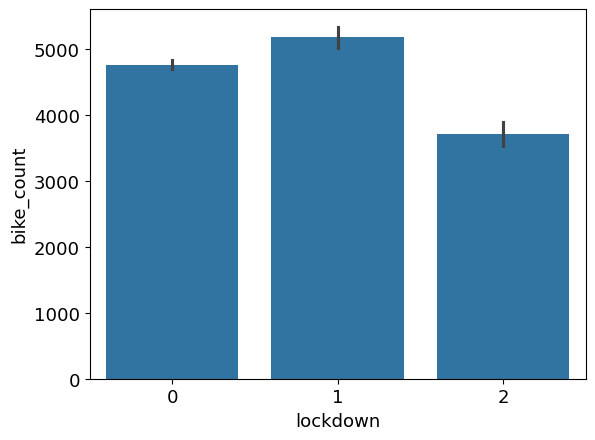

In [81]:
lockdown_plot = sns.barplot(data=df, x= 'lockdown' , y = 'bike_count')
plt.show()

This doesn't seem to make a lot of sense. However, what is important to be considered: hard lockdown phases are always in the winter, while soft lockdowns were in the summer. In general, more people ride their bikes in the summer than in the winter. So maybe the season plays a more major role here?

<Axes: xlabel='lockdown', ylabel='bike_count'>

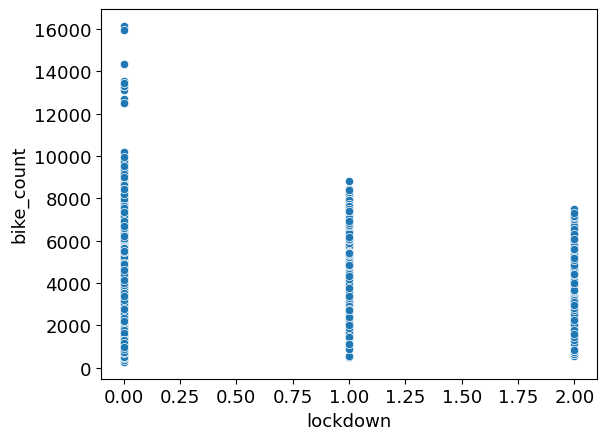

In [82]:
sns.scatterplot(data=df, x='lockdown', y='bike_count') 

<Axes: xlabel='lockdown', ylabel='bike_count'>

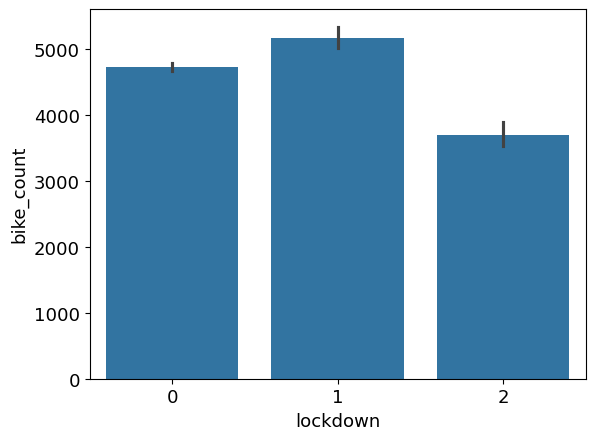

In [83]:
filtered_df = df[df['bike_count'] <= 10000]
sns.barplot(data=filtered_df, x='lockdown', y='bike_count') 

In [84]:
df.lockdown.unique()

array([0, 2, 1], dtype=int64)

### Adding a column for the season

In [85]:
def assign_season(date):
    if date.month in [3, 4, 5]:
        return 0  # Spring
    elif date.month in [6, 7, 8]:
        return 1  # Summer
    elif date.month in [9, 10, 11]:
        return 2  # Autumn
    else:
        return 3  # Winter


In [86]:
df['season'] = df['date'].apply(assign_season)

In [87]:
len(df)

4291

In [88]:
df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,lockdown,season
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0,0
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0,0
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0,0
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0,0,0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0,0,0


In [89]:
df.iloc[3022:3027]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,lockdown,season
3022,2020-08-05,7607.0,21.894444,48.055556,2.711111,76.666667,58240.555556,0.0,812,10.8,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1,1
3023,2020-08-06,7512.0,24.494444,48.444444,3.777778,66.666667,58312.222222,0.0,810,10.3,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1,1
3024,2020-08-07,7056.0,27.566667,48.888889,3.333333,55.000000,53134.444444,0.0,800,11.0,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1,1
3025,2020-08-08,5135.0,28.877778,43.222222,2.338889,123.888889,44113.888889,0.0,787,9.2,0.0,0.0,sommerferien,1,No Holiday,0,1,0,1,1
3026,2020-08-09,2493.0,28.905556,43.277778,2.516667,141.111111,46730.555556,0.0,769,11.0,0.0,0.0,sommerferien,1,No Holiday,0,1,0,1,1


In [90]:
df.tail()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,lockdown,season
4286,2024-01-21,994.0,-1.500000,87.666667,1.587500,187.500000,14942.500000,0.0,191,7.7,0.0,0.0,No Holiday,0,No Holiday,0,0,0,0,3
4287,2024-01-22,3398.0,7.479167,76.791667,7.075000,223.750000,47245.416667,5.4,0,18.0,1.0,6.0,No Holiday,0,No Holiday,0,0,1,0,3
4288,2024-01-23,4427.0,8.358333,74.541667,7.250000,231.250000,38257.916667,0.5,164,16.6,0.5,3.0,No Holiday,0,No Holiday,0,0,1,0,3
4289,2024-01-24,4124.0,11.945833,72.291667,8.350000,234.583333,45765.833333,1.9,7,18.8,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0,3
4290,2024-01-25,4594.0,9.366667,85.083333,3.345833,229.583333,23374.583333,1.0,220,7.5,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0,3


<Axes: xlabel='season', ylabel='bike_count'>

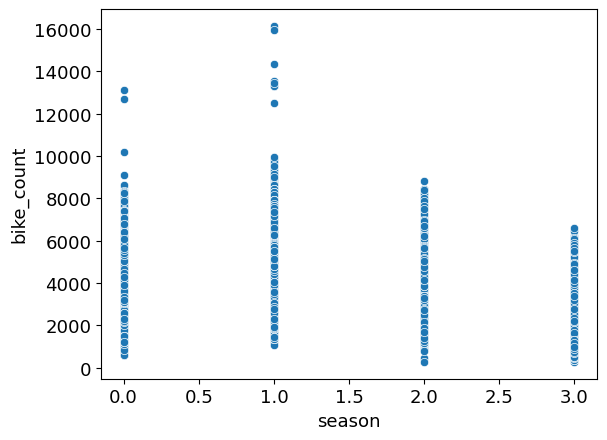

In [91]:
sns.scatterplot(data=df, x='season', y='bike_count') 

In [92]:
df.to_csv(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\bike_data_enhanced_with_lockdown_data.csv", index=False)

Since the lockdown Data doesn't seem to provide any meaningful information, I will drop it and also drop all values from 2020, since that was an anomaly.

In [93]:
data_2020 = df[df['date'].dt.year == 2020]

In [94]:
data_2020.describe()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,lockdown,season
count,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2020-07-01 12:00:00,4853.814208,12.994613,68.752169,3.588194,172.970008,44438.598676,1.217486,329.300546,9.781967,0.189891,1.139344,0.243169,0.032787,0.259563,0.691257,1.338798,1.494536
min,2020-01-01 00:00:00,533.000000,-2.800000,32.500000,0.805556,24.444444,532.777778,0.000000,0.000000,2.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2020-04-01 06:00:00,3179.750000,6.495833,54.361111,2.206944,118.888889,35510.138889,0.000000,40.000000,7.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000
50%,2020-07-01 12:00:00,5186.500000,12.772222,69.666667,3.230556,201.111111,48197.777778,0.000000,260.000000,9.300000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000
75%,2020-09-30 18:00:00,6424.250000,18.872222,82.833333,4.493056,227.083333,56351.805556,0.575000,616.000000,11.975000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000
max,2020-12-31 00:00:00,8462.000000,28.950000,99.388889,11.611111,277.222222,71671.666667,25.900000,885.000000,28.500000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000
std,NaN,2043.752124,7.337280,16.521286,1.860473,69.246182,16319.112835,2.977840,294.674703,4.065141,0.388367,2.298238,0.429584,0.178322,0.438995,0.462607,0.743905,1.119551


In [95]:
df.describe()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,lockdown,season
count,4291,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000
mean,2018-03-10 23:36:10.403169280,4735.174603,12.538591,73.092589,3.475722,176.768780,34281.616807,1.539361,309.323701,9.544232,0.192205,1.162666,0.232580,0.033326,0.249359,0.686320,0.262410,1.498951
min,2012-04-25 00:00:00,273.000000,-7.827778,31.277778,0.600000,16.666667,207.777778,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,3220.000000,6.427778,62.611111,2.144444,129.722222,21317.777778,0.000000,33.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2018-03-10 00:00:00,4880.000000,12.450000,74.666667,3.122222,206.666667,35432.222222,0.000000,246.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,2021-02-16 12:00:00,6208.000000,18.705556,84.111111,4.355556,228.888889,46983.611111,1.000000,548.000000,11.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
max,2024-01-25 00:00:00,16149.000000,31.794444,100.000000,12.233333,340.000000,71937.777778,58.300000,909.000000,31.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000
std,NaN,1981.068801,7.636231,14.120612,1.816690,69.225224,16381.273131,3.911284,280.267835,3.956637,0.384261,2.320596,0.422526,0.179506,0.432692,0.464042,0.579069,1.107586


In [96]:
total_mean = df['bike_count'].mean()
print(f"Total Mean: {total_mean}")

# Calculate the mean for a specific year
year = 2020  # Replace with the year you're interested in
df_year = df[df['date'].dt.year == year]
mean_year = df_year['bike_count'].mean()
print(f"Mean for {year}: {mean_year}")

Total Mean: 4735.174602686989
Mean for 2020: 4853.814207650274


In [97]:
len(df)

4291

In [98]:
# Remove the year 2020 from the dataset
df = df[df['date'].dt.year != 2020]

In [99]:
len(df)

3925

In [100]:
df.describe()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,lockdown,season
count,3925,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000
mean,2017-12-22 07:50:42.343949312,4724.111648,12.496068,73.497326,3.465235,177.123009,33334.494421,1.569376,307.460892,9.522064,0.192420,1.164841,0.231592,0.033376,0.248408,0.685860,0.162038,1.499363
min,2012-04-25 00:00:00,273.000000,-7.827778,31.277778,0.600000,16.666667,207.777778,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-01-01 00:00:00,3235.000000,6.422222,63.333333,2.133333,131.111111,20546.666667,0.000000,31.000000,6.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2017-09-08 00:00:00,4865.000000,12.422222,75.000000,3.111111,207.777778,34222.222222,0.000000,246.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,2021-05-19 00:00:00,6190.000000,18.688889,84.277778,4.338889,229.444444,45690.000000,1.100000,546.000000,11.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
max,2024-01-25 00:00:00,16149.000000,31.794444,100.000000,12.233333,340.000000,71937.777778,58.300000,909.000000,31.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000
std,NaN,1975.026895,7.663032,13.808657,1.812440,69.221467,16064.991208,3.986181,278.852846,3.946168,0.383926,2.322948,0.421904,0.179639,0.432144,0.464232,0.443823,1.106607


In [101]:
total_mean_no_2020 = df['bike_count'].mean()
print(f"Total Mean without 2020: {total_mean}")

Total Mean without 2020: 4735.174602686989


In [102]:
# Remove the lockdown column
df = df.drop(columns=['lockdown'])

In [103]:
df.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0,0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,No Holiday,0,No Holiday,0,0,0,0


In [104]:
filtered_df = df[['bike_count', 'temperature', 'humidity', 'windspeed', 'visibility', 'precipitation', 'sun']]

In [105]:
summary = filtered_df.describe()
summary

,bike_count,temperature,humidity,windspeed,visibility,precipitation,sun
count,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000
mean,4724.111648,12.496068,73.497326,3.465235,33334.494421,1.569376,307.460892
std,1975.026895,7.663032,13.808657,1.812440,16064.991208,3.986181,278.852846
min,273.000000,-7.827778,31.277778,0.600000,207.777778,0.000000,0.000000
25%,3235.000000,6.422222,63.333333,2.133333,20546.666667,0.000000,31.000000
50%,4865.000000,12.422222,75.000000,3.111111,34222.222222,0.000000,246.000000
75%,6190.000000,18.688889,84.277778,4.338889,45690.000000,1.100000,546.000000
max,16149.000000,31.794444,100.000000,12.233333,71937.777778,58.300000,909.000000


In [106]:
summary_latex = summary.style.to_latex()

In [107]:
with open(r'C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\summary_data.tex', 'w') as file:
    file.write(summary_latex)

In [108]:
df[df['date'].dt.year == 2020]

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season


### Dealing with Outliers

In [109]:
df_over_10000 = df[df['bike_count'] > 10000]

In [110]:
df_over_10000

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season
2202,2018-05-08,13109.0,21.122222,41.388889,4.377778,50.000000,28496.111111,0.0,833,10.9,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
2203,2018-05-09,12701.0,20.533333,48.666667,3.055556,82.777778,36868.333333,0.0,714,9.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
2222,2018-05-28,10200.0,24.516667,65.333333,3.266667,70.000000,14847.222222,0.0,570,9.8,0.0,0.0,pfingstferien,1,No Holiday,0,1,1,0
2230,2018-06-05,13292.0,24.144444,58.777778,3.122222,80.000000,24607.222222,0.0,806,10.2,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2231,2018-06-06,13538.0,23.711111,62.500000,2.422222,185.555556,16275.000000,2.0,678,6.3,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2232,2018-06-07,13316.0,21.488889,75.388889,2.772222,230.000000,25608.333333,3.3,212,5.9,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2233,2018-06-08,16149.0,22.727778,71.944444,2.055556,152.222222,15031.111111,2.9,575,9.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2234,2018-06-09,14357.0,22.283333,78.111111,2.688889,238.888889,14092.777778,2.0,480,8.1,0.0,0.0,No Holiday,0,No Holiday,0,0,0,1
2238,2018-06-13,15952.0,16.533333,63.388889,4.100000,203.888889,36424.444444,0.0,16,9.3,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2288,2018-08-02,13450.0,29.683333,49.000000,2.391667,337.500000,33195.000000,0.0,626,7.2,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1


In [111]:
len(df_over_10000)

11

In [112]:
df_over_12000 = df[df['bike_count'] > 12000]

In [113]:
df_over_12000

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season
2202,2018-05-08,13109.0,21.122222,41.388889,4.377778,50.000000,28496.111111,0.0,833,10.9,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
2203,2018-05-09,12701.0,20.533333,48.666667,3.055556,82.777778,36868.333333,0.0,714,9.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,0
2230,2018-06-05,13292.0,24.144444,58.777778,3.122222,80.000000,24607.222222,0.0,806,10.2,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2231,2018-06-06,13538.0,23.711111,62.500000,2.422222,185.555556,16275.000000,2.0,678,6.3,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2232,2018-06-07,13316.0,21.488889,75.388889,2.772222,230.000000,25608.333333,3.3,212,5.9,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2233,2018-06-08,16149.0,22.727778,71.944444,2.055556,152.222222,15031.111111,2.9,575,9.0,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2234,2018-06-09,14357.0,22.283333,78.111111,2.688889,238.888889,14092.777778,2.0,480,8.1,0.0,0.0,No Holiday,0,No Holiday,0,0,0,1
2238,2018-06-13,15952.0,16.533333,63.388889,4.100000,203.888889,36424.444444,0.0,16,9.3,0.0,0.0,No Holiday,0,No Holiday,0,0,1,1
2288,2018-08-02,13450.0,29.683333,49.000000,2.391667,337.500000,33195.000000,0.0,626,7.2,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1
2289,2018-08-03,12502.0,29.677778,49.611111,3.194444,83.333333,24296.111111,0.0,822,12.6,0.0,0.0,sommerferien,1,No Holiday,0,1,1,1


In [114]:
len(df_over_12000)

10

There are 10 lines with a bike count over 12000. Since those counts are far above the usual average, these rows will be dropped.

In [115]:
len(df)

3925

In [116]:
# Specify the threshold value
threshold = 12000

# Drop rows with bike count over the threshold
df = df.drop(df[df['bike_count'] > threshold].index)

In [117]:
len(df)

3915

In [118]:
df.describe()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season
count,3915,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000
mean,2017-12-21 21:15:35.172413696,4700.835816,12.468751,73.532114,3.466377,177.155465,33354.532863,1.570779,306.774457,9.523780,0.192912,1.167816,0.231673,0.033461,0.248531,0.685313,1.501149
min,2012-04-25 00:00:00,273.000000,-7.827778,31.277778,0.600000,16.666667,207.777778,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-12-29 12:00:00,3222.000000,6.397222,63.361111,2.127778,131.111111,20551.111111,0.000000,31.000000,6.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2017-09-03 00:00:00,4862.000000,12.411111,75.000000,3.116667,207.777778,34241.666667,0.000000,246.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,2021-05-21 12:00:00,6182.000000,18.669444,84.333333,4.338889,229.444444,45731.666667,1.100000,545.000000,11.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,2024-01-25 00:00:00,10200.000000,31.794444,100.000000,12.233333,340.000000,71937.777778,58.300000,909.000000,31.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3.000000
std,NaN,1922.055154,7.651280,13.795854,1.814267,69.167709,16075.483974,3.990632,278.571794,3.949804,0.384292,2.325166,0.421955,0.179860,0.432217,0.464450,1.107270


In [119]:
top_5_temps = df['temperature'].nlargest(5)
print(top_5_temps)

1166    31.794444
2645    31.083333
3705    30.661111
1165    30.622222
1164    30.583333
Name: temperature, dtype: float64


In [120]:
bottom_5_temps = df['temperature'].nsmallest(5)
print(bottom_5_temps)

3212   -7.827778
3887   -6.811111
3886   -6.716667
2134   -6.644444
1733   -6.544444
Name: temperature, dtype: float64


In [121]:
bottom_5_temps = df['precipitation'].nsmallest(5)
print(bottom_5_temps)

0    0.0
1    0.0
3    0.0
5    0.0
6    0.0
Name: precipitation, dtype: float64


In [122]:
df.to_csv(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\bike_data_enhanced_without_lockdown_data.csv", index=False)